# Object Detection with YOLO (You Only Look Once)
### HW2 @ DL Course, Dr. Soleymani

*Full Name:* Ehsan Hassanbeygi

*SID:* 402211723

In this question you will implement the YOLO object detection algorithm using PyTorch. YOLO is a real-time object detection system that can recognize multiple objects in an image while also predicting their bounding boxes.

# Setup
## Install required packages
This cell installs the torch-summary package, which provides a utility function to summarize the layers and parameters of a PyTorch model.


In [1]:
!pip install torch-summary

# Load and preprocess the VOC dataset

In [2]:
import os
import tarfile
import urllib.request

# the VOC object classes.
CLASSES = (
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
)  # refer to https://github.com/pjreddie/darknet/blob/master/data/voc.names
CLASS2NUM = {class_: idx for idx, class_ in enumerate(CLASSES)}

# download the VOC dataset (this takes a while!) if it's not already downloaded.
if not os.path.exists("VOCdevkit"):
    if not os.path.exists("VOC.tar"):
        urllib.request.urlretrieve(
            "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar",
            "VOC.tar",
        )
    with tarfile.open("VOC.tar") as tar:
        tar.extractall()

# Load and preprocess images
These functions are used to load and preprocess individual images or batches of images from the VOC dataset. The `load_image` function loads a single image, resizes it to the specified size, and pads it if necessary. The `load_image_batch` function loads a batch of images by calling `load_image` for each image index. The `show_images` function displays the loaded images using IPython's display functionality.

In [3]:
import torchvision
from PIL import Image


def load_image(idx, size, device="cpu"):
    filename = f"VOCdevkit/VOC2012/JPEGImages/2008_{str(idx).zfill(6)}.jpg"
    img = Image.open(filename)
    transforms = [torchvision.transforms.ToTensor()]
    try:
        width, height = size
    except TypeError:
        width = height = size

    scale = min(width / img.width, height / img.height)
    new_width, new_height = int(img.width * scale), int(img.height * scale)
    diff_width, diff_height = width - new_width, height - new_height

    resize = torchvision.transforms.Resize(size=(new_height, new_width))
    pad = torchvision.transforms.Pad(
        padding=(
            diff_width // 2,
            diff_height // 2,
            diff_width // 2 + diff_width % 2,
            diff_height // 2 + diff_height % 2,
        )
    )

    transforms = [resize, pad] + transforms
    transformation = torchvision.transforms.Compose(transforms)
    x = transformation(img).to(device)
    return x

In [4]:
import torch


def load_image_batch(idxs, size, device="cpu"):
    imgs = [load_image(idx, size=size, device="cpu") for idx in idxs]
    x = torch.stack(imgs, 0)
    return x.to(device)

In [5]:
from IPython.display import display


def show_images(x):
    transform = torchvision.transforms.ToPILImage()
    if x.dim() == 3:
        display(transform(x))
    elif x.dim() == 4:
        for xx in x:
            display(transform(xx))
    else:
        raise ValueError

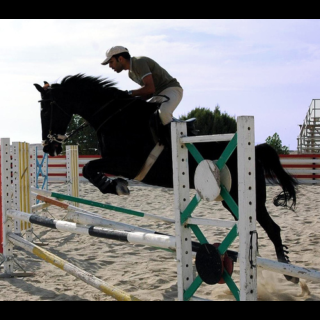

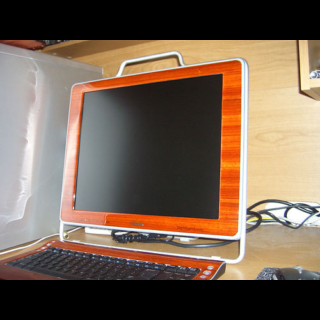

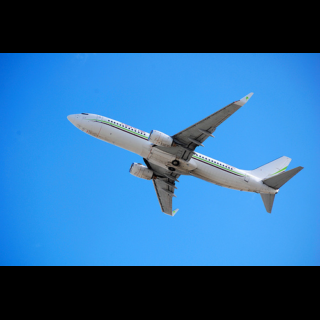

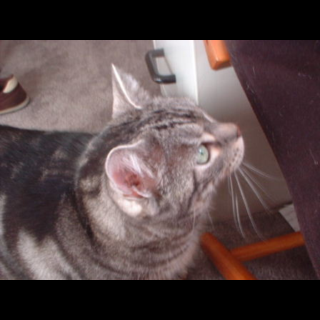

In [6]:
imgs = load_image_batch([8, 16, 33, 60], size=320)
show_images(imgs)

# YOLO Architecture
Define the TinyYOLOv2 model as follows:

### Convolutional Layer 1
- Batch Normalization: Yes
- Filters: 16
- Kernel Size: 3
- Stride: 1
- Padding: 1
- Activation Function: Leaky ReLU ($\text{slope}=0.1$)

### Max Pooling Layer 1
- Pool Size: 2
- Stride: 2

### Convolutional Layer 2
- Batch Normalization: Yes
- Filters: 32
- Kernel Size: 3
- Stride: 1
- Padding: 1
- Activation Function: Leaky ReLU

### Max Pooling Layer 2
- Pool Size: 2
- Stride: 2

### Convolutional Layer 3
- Batch Normalization: Yes
- Filters: 64
- Kernel Size: 3
- Stride: 1
- Padding: 1
- Activation Function: Leaky ReLU

### Max Pooling Layer 3
- Pool Size: 2
- Stride: 2

### Convolutional Layer 4
- Batch Normalization: Yes
- Filters: 128
- Kernel Size: 3
- Stride: 1
- Padding: 1
- Activation Function: Leaky ReLU

### Max Pooling Layer 4
- Pool Size: 2
- Stride: 2

### Convolutional Layer 5
- Batch Normalization: Yes
- Filters: 256
- Kernel Size: 3
- Stride: 1
- Padding: 1
- Activation Function: Leaky ReLU

### Max Pooling Layer 5
- Pool Size: 2
- Stride: 2

### Convolutional Layer 6
- Batch Normalization: Yes
- Filters: 512
- Kernel Size: 3
- Stride: 1
- Padding: 1
- Activation Function: Leaky ReLU

### Max Pooling Layer 6
- Pool Size: 2
- Stride: 1
- hint: use ReflectionPad2d in this layer 

### Convolutional Layer 7
- Batch Normalization: Yes
- Filters: 1024
- Kernel Size: 3
- Stride: 1
- Padding: 1
- Activation Function: Leaky ReLU

### Convolutional Layer 8
- Batch Normalization: Yes
- Filters: 1024
- Kernel Size: 3
- Stride: 1
- Padding: 1
- Activation Function: Leaky ReLU

### Convolutional Layer 9
- Filters: 425
- Kernel Size: 1
- Stride: 1
- Padding: 1
- Activation Function: Linear

* Note that the convolution layers in TinyYOLO-v2 don't have `bias` parameters
* refer to https://github.com/pjreddie/darknet/blob/master/cfg/yolov2-tiny.cfg

In [7]:
import torch


class TinyYOLOv2(torch.nn.Module):
    def __init__(
        self,
        num_classes=20,
        anchors=(
            (1.08, 1.19),
            (3.42, 4.41),
            (6.63, 11.38),
            (9.42, 5.11),
            (16.62, 10.52),
        ),
    ):
        super().__init__()

        # Parameters
        self.register_buffer("anchors", torch.tensor(anchors))
        self.num_classes = num_classes

        # Layers
        ################################## TODO ##################################
        model_c_out = len(anchors) * (5 + num_classes)

        self.relu = torch.nn.LeakyReLU(0.1, inplace=True)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.pool2 = torch.nn.MaxPool2d(2, 1)
        self.padding = torch.nn.ReflectionPad2d((0, 1, 0, 1))
        self.norm1 = torch.nn.BatchNorm2d(16, momentum=0.1)
        self.conv1 = torch.nn.Conv2d(
            3, 16, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.norm2 = torch.nn.BatchNorm2d(32, momentum=0.1)
        self.conv2 = torch.nn.Conv2d(
            16, 32, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.norm3 = torch.nn.BatchNorm2d(64, momentum=0.1)
        self.conv3 = torch.nn.Conv2d(
            32, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.norm4 = torch.nn.BatchNorm2d(128, momentum=0.1)
        self.conv4 = torch.nn.Conv2d(
            64, 128, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.norm5 = torch.nn.BatchNorm2d(256, momentum=0.1)
        self.conv5 = torch.nn.Conv2d(
            128, 256, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.norm6 = torch.nn.BatchNorm2d(512, momentum=0.1)
        self.conv6 = torch.nn.Conv2d(
            256, 512, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.norm7 = torch.nn.BatchNorm2d(1024, momentum=0.1)
        self.conv7 = torch.nn.Conv2d(
            512, 1024, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.norm8 = torch.nn.BatchNorm2d(1024, momentum=0.1)
        self.conv8 = torch.nn.Conv2d(
            1024, 1024, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.conv9 = torch.nn.Conv2d(
            1024, model_c_out, kernel_size=1, stride=1, padding=0
        )

    def forward(self, x, yolo=True):
        ################################## TODO ##################################
        x = self.relu(self.pool1(self.norm1(self.conv1(x))))
        x = self.relu(self.pool1(self.norm2(self.conv2(x))))
        x = self.relu(self.pool1(self.norm3(self.conv3(x))))
        x = self.relu(self.pool1(self.norm4(self.conv4(x))))
        x = self.relu(self.pool1(self.norm5(self.conv5(x))))
        x = self.relu(self.pool2(self.padding(self.norm6(self.conv6(x)))))
        x = self.relu(self.norm7(self.conv7(x)))
        x = self.relu(self.norm8(self.conv8(x)))
        x = self.conv9(x)

        if yolo:
            x = self.yolo(x)
        return x

    def yolo(self, x):
        # store the original shape of x
        nB, _, nH, nW = x.shape

        # reshape the x-tensor: (batch size, # anchors, height, width, 5+num_classes)
        x = x.view(nB, self.anchors.shape[0], -1, nH, nW).permute(0, 1, 3, 4, 2)

        # get normalized auxiliary tensors
        anchors = self.anchors.to(dtype=x.dtype, device=x.device)
        range_y, range_x = torch.meshgrid(
            torch.arange(nH, dtype=x.dtype, device=x.device),
            torch.arange(nW, dtype=x.dtype, device=x.device),
        )
        anchor_x, anchor_y = anchors[:, 0], anchors[:, 1]

        # compute boxes.
        ################################## TODO ##################################
        reshaped_range_x = torch.reshape(range_x, (1, 1, *range_x.shape, 1))
        reshaped_range_y = torch.reshape(range_y, (1, 1, *range_y.shape, 1))
        reshaped_anchor_x = torch.reshape(anchor_x, (1, -1, 1, 1, 1))
        reshaped_anchor_y = torch.reshape(anchor_y, (1, -1, 1, 1, 1))

        x = torch.cat(
            [
                (torch.sigmoid(x[:, :, :, :, 0].unsqueeze(-1)) + reshaped_range_x) / nW,
                (torch.sigmoid(x[:, :, :, :, 1].unsqueeze(-1)) + reshaped_range_y) / nH,
                (torch.exp(x[:, :, :, :, 2].unsqueeze(-1)) * reshaped_anchor_x) / nW,
                (torch.exp(x[:, :, :, :, 3].unsqueeze(-1)) * reshaped_anchor_y) / nH,
                torch.sigmoid(x[:, :, :, :, 4].unsqueeze(-1)),
                torch.softmax(x[:, :, :, :, 5:], dim=-1),
            ],
            -1,
        )

        return x  # (batch_size, # anchors, height, width, 5+num_classes)

In [8]:
from torchsummary import summary

network = TinyYOLOv2()
summary(network, (3, 320, 320))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 320, 320]        432
├─BatchNorm2d: 1-2                       [-1, 16, 320, 320]        32
├─MaxPool2d: 1-3                         [-1, 16, 160, 160]        --
├─LeakyReLU: 1-4                         [-1, 16, 160, 160]        --
├─Conv2d: 1-5                            [-1, 32, 160, 160]        4,608
├─BatchNorm2d: 1-6                       [-1, 32, 160, 160]        64
├─MaxPool2d: 1-7                         [-1, 32, 80, 80]          --
├─LeakyReLU: 1-8                         [-1, 32, 80, 80]          --
├─Conv2d: 1-9                            [-1, 64, 80, 80]          18,432
├─BatchNorm2d: 1-10                      [-1, 64, 80, 80]          128
├─MaxPool2d: 1-11                        [-1, 64, 40, 40]          --
├─LeakyReLU: 1-12                        [-1, 64, 40, 40]          --
├─Conv2d: 1-13                           [-1, 128, 40, 40]         73,728
├─

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 320, 320]        432
├─BatchNorm2d: 1-2                       [-1, 16, 320, 320]        32
├─MaxPool2d: 1-3                         [-1, 16, 160, 160]        --
├─LeakyReLU: 1-4                         [-1, 16, 160, 160]        --
├─Conv2d: 1-5                            [-1, 32, 160, 160]        4,608
├─BatchNorm2d: 1-6                       [-1, 32, 160, 160]        64
├─MaxPool2d: 1-7                         [-1, 32, 80, 80]          --
├─LeakyReLU: 1-8                         [-1, 32, 80, 80]          --
├─Conv2d: 1-9                            [-1, 64, 80, 80]          18,432
├─BatchNorm2d: 1-10                      [-1, 64, 80, 80]          128
├─MaxPool2d: 1-11                        [-1, 64, 40, 40]          --
├─LeakyReLU: 1-12                        [-1, 64, 40, 40]          --
├─Conv2d: 1-13                           [-1, 128, 40, 40]         73,728
├─

# Visualize the model output

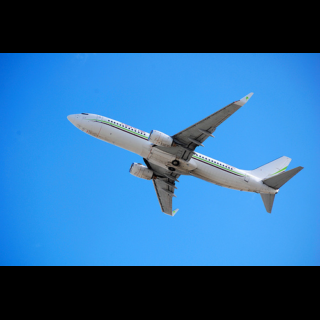

torch.Size([1, 5, 10, 10, 25])


In [9]:
network = TinyYOLOv2()
input_tensor = load_image_batch([33], 320)  # batch with single image of an airplane
show_images(input_tensor)
output_tensor = network(input_tensor)
print(output_tensor.shape)

In [10]:
from PIL import ImageDraw


def show_images_with_boxes(input_tensor, output_tensor):
    to_img = torchvision.transforms.ToPILImage()
    for img, predictions in zip(input_tensor, output_tensor):
        img = to_img(img)
        if 0 in predictions.shape:  # empty tensor
            display(img)
            continue
        confidences = predictions[..., 4].flatten()
        boxes = (
            predictions[..., :4].contiguous().view(-1, 4)
        )  # only take first four features: x0, y0, w, h
        classes = predictions[..., 5:].contiguous().view(boxes.shape[0], -1)
        boxes[:, ::2] *= img.width
        boxes[:, 1::2] *= img.height
        boxes = (
            torch.stack(
                [
                    boxes[:, 0] - boxes[:, 2] / 2,
                    boxes[:, 1] - boxes[:, 3] / 2,
                    boxes[:, 0] + boxes[:, 2] / 2,
                    boxes[:, 1] + boxes[:, 3] / 2,
                ],
                -1,
            )
            .cpu()
            .to(torch.int32)
            .numpy()
        )
        for box, confidence, class_ in zip(boxes, confidences, classes):
            if confidence < 0.01:
                continue  # don't show boxes with very low confidence
            # make sure the box fits within the picture:
            box = [
                max(0, int(box[0])),
                max(0, int(box[1])),
                min(img.width - 1, int(box[2])),
                min(img.height - 1, int(box[3])),
            ]
            try:  # either the class is given as the sixth feature
                idx = int(class_.item())
            except:  # or the 20 softmax probabilities are given as features 6-25
                idx = int(torch.max(class_, 0)[1].item())
            try:
                class_ = CLASSES[idx]  # the first index of torch.max is the argmax.
            except (
                IndexError
            ):  # if the class index does not exist, don't draw anything:
                continue

            color = (  # green color when confident, red color when not confident.
                int((1 - (confidence.item()) ** 0.8) * 255),
                int((confidence.item()) ** 0.8 * 255),
                0,
            )
            draw = ImageDraw.Draw(img)
            draw.rectangle(box, outline=color)
            draw.text(box[:2], class_, fill=color)

        display(img)

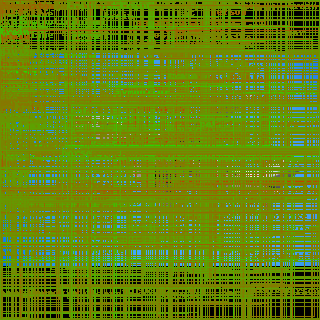

In [11]:
show_images_with_boxes(input_tensor, output_tensor)

# Load model weights

In [12]:
if not os.path.exists("yolov2-tiny-voc.weights"):
    urllib.request.urlretrieve(
        "https://pjreddie.com/media/files/yolov2-tiny-voc.weights",
        "yolov2-tiny-voc.weights",
    )

In [13]:
import numpy as np


def load_weights(network, filename="yolov2-tiny-voc.weights"):
    with open(filename, "rb") as file:
        version = np.fromfile(file, count=3, dtype=np.int32)
        seen_so_far = np.fromfile(file, count=1, dtype=np.int32)
        weights = np.fromfile(file, dtype=np.float32)
        idx = 0
        for layer in network.children():
            if isinstance(layer, torch.nn.Conv2d):
                if layer.bias is not None:
                    n = layer.bias.numel()
                    layer.bias.data[:] = torch.from_numpy(
                        weights[idx : idx + n]
                    ).view_as(layer.bias.data)
                    idx += n
                n = layer.weight.numel()
                layer.weight.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(
                    layer.weight.data
                )
                idx += n
            if isinstance(layer, torch.nn.BatchNorm2d):
                n = layer.bias.numel()
                layer.bias.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(
                    layer.bias.data
                )
                idx += n
                layer.weight.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(
                    layer.weight.data
                )
                idx += n
                layer.running_mean.data[:] = torch.from_numpy(
                    weights[idx : idx + n]
                ).view_as(layer.running_mean)
                idx += n
                layer.running_var.data[:] = torch.from_numpy(
                    weights[idx : idx + n]
                ).view_as(layer.running_var)
                idx += n
            if isinstance(layer, torch.nn.Linear):
                n = layer.bias.numel()
                layer.bias.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(
                    layer.bias.data
                )
                idx += n
                n = layer.weight.numel()
                layer.weight.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(
                    layer.weight.data
                )
                idx += n

In [14]:
load_weights(network)

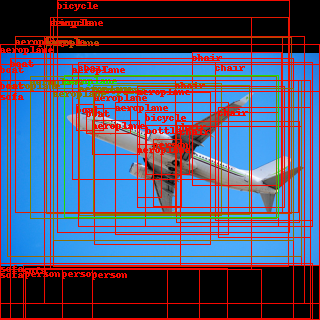

In [15]:
input_tensor = load_image_batch([33], 320)  # batch with single image of an airplane
output_tensor = network(input_tensor)
show_images_with_boxes(input_tensor, output_tensor)

# Filter bounding boxes based on confidence scores

In [16]:
def filter_boxes(output_tensor, threshold):
    b, a, h, w, c = output_tensor.shape
    x = output_tensor.contiguous().view(b, a * h * w, c)

    boxes = x[:, :, 0:4]
    confidence = x[:, :, 4]
    scores, idx = torch.max(x[:, :, 5:], -1)
    idx = idx.float()
    scores = scores * confidence
    mask = scores > threshold

    filtered = []
    for c, s, i, m in zip(boxes, scores, idx, mask):
        if m.any():
            detected = torch.cat([c[m, :], s[m, None], i[m, None]], -1)
        else:
            detected = torch.zeros((0, 6), dtype=x.dtype, device=x.device)
        filtered.append(detected)
    return filtered

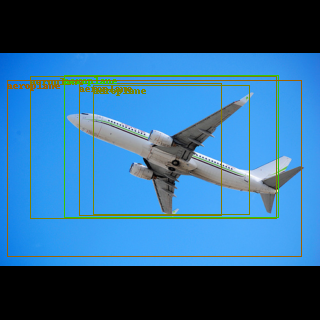

In [17]:
filtered_tensor = filter_boxes(output_tensor, 0.2)
show_images_with_boxes(input_tensor, filtered_tensor)

intersection=8
union=32
iou=0.25


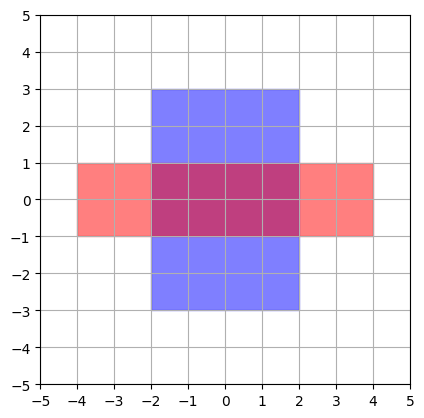

In [18]:
import matplotlib.pyplot as plt

bboxes1 = torch.tensor([[4.0, 6.0]])  # w, h
bboxes2 = torch.tensor([[8.0, 2.0]])  # w, h

print(f"intersection=8")
print(f"union=32")
print(f"iou=0.25")

plt.axis("scaled")
plt.gca().add_patch(
    plt.matplotlib.patches.Rectangle(
        (-bboxes1[0, 0] / 2, -bboxes1[0, 1] / 2),
        bboxes1[0, 0],
        bboxes1[0, 1],
        color="blue",
        alpha=0.5,
    )
)
plt.gca().add_patch(
    plt.matplotlib.patches.Rectangle(
        (-bboxes2[0, 0] / 2, -bboxes2[0, 1] / 2),
        bboxes2[0, 0],
        bboxes2[0, 1],
        color="red",
        alpha=0.5,
    )
)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.xticks(np.linspace(-5, 5, 11))
plt.yticks(np.linspace(-5, 5, 11))
plt.grid(True)
plt.show()

intersection=3
union=25
iou=0.12


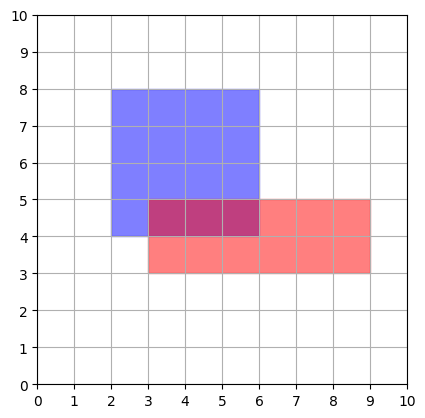

In [19]:
bboxes1 = torch.tensor([[4.0, 6.0, 4.0, 4.0]])  # x, y, w, h
bboxes2 = torch.tensor([[6.0, 4.0, 6.0, 2.0]])  # x, y, w, h

print(f"intersection=3")
print(f"union=25")
print(f"iou=0.12")

plt.axis("scaled")
plt.gca().add_patch(
    plt.matplotlib.patches.Rectangle(
        (-bboxes1[0, 2] / 2 + bboxes1[0, 0], -bboxes1[0, 3] / 2 + bboxes1[0, 1]),
        bboxes1[0, 2],
        bboxes1[0, 3],
        color="blue",
        alpha=0.5,
    )
)
plt.gca().add_patch(
    plt.matplotlib.patches.Rectangle(
        (-bboxes2[0, 2] / 2 + bboxes2[0, 0], -bboxes2[0, 3] / 2 + bboxes2[0, 1]),
        bboxes2[0, 2],
        bboxes2[0, 3],
        color="red",
        alpha=0.5,
    )
)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xticks(np.linspace(0, 10, 11))
plt.yticks(np.linspace(0, 10, 11))
plt.grid(True)
plt.show()

# Non-maximum suppression (NMS)
This section discusses the concept of non-maximum suppression (NMS), which is a technique used to remove redundant bounding boxes that may overlap with each other. It provides examples and visualizations to explain the intersection over union (IoU) calculation and the NMS algorithm.

In [20]:
def iou_wh(bboxes1, bboxes2):
    """calculate iou between each bbox in `bboxes1` with each bbox in `bboxes2`

    The bboxes should be defined by their width and height and are centered around (0,0)

    """

    w1 = bboxes1[..., 0].view(-1)
    h1 = bboxes1[..., 1].view(-1)
    w2 = bboxes2[..., 0].view(-1)
    h2 = bboxes2[..., 1].view(-1)

    intersections = torch.min(w1[:, None], w2[None, :]) * torch.min(
        h1[:, None], h2[None, :]
    )
    unions = (w1 * h1)[:, None] + (w2 * h2)[None, :] - intersections
    ious = (intersections / unions).reshape(*bboxes1.shape[:-1], *bboxes2.shape[:-1])

    return ious

In [21]:
def iou(bboxes1, bboxes2):
    """calculate iou between each bbox in `bboxes1` with each bbox in `bboxes2`"""
    ################################## TODO ##################################
    bb1_x, bb1_y, bb1_w, bb1_h = torch.chunk(bboxes1[..., :4].reshape(-1, 4), 4, dim=1)
    bb2_x, bb2_y, bb2_w, bb2_h = torch.chunk(bboxes2[..., :4].reshape(-1, 4), 4, dim=1)

    bb1_x1, bb1_x2 = bb1_x - bb1_w / 2, bb1_x + bb1_w / 2
    bb1_y1, bb1_y2 = bb1_y - bb1_h / 2, bb1_y + bb1_h / 2

    bb2_x1, bb2_x2 = bb2_x - bb2_w / 2, bb2_x + bb2_w / 2
    bb2_y1, bb2_y2 = bb2_y - bb2_h / 2, bb2_y + bb2_h / 2

    zeros = torch.tensor(0, dtype=bb1_x1.dtype, device=bb1_x1.device)

    diff_x = torch.min(bb1_x2, bb2_x2.T) - torch.max(bb1_x1, bb2_x1.T)
    diff_y = torch.min(bb1_y2, bb2_y2.T) - torch.max(bb1_y1, bb2_y1.T)

    intersections = torch.max(diff_x, zeros) * torch.max(diff_y, zeros)

    bb1_area = (bb1_x2 - bb1_x1) * (bb1_y2 - bb1_y1)
    bb2_area = (bb2_x2 - bb2_x1) * (bb2_y2 - bb2_y1)
    unions = (bb1_area + bb2_area.T) - intersections

    return (intersections / unions).reshape(*bboxes1.shape[:-1], *bboxes2.shape[:-1])

In [22]:
def nms(filtered_tensor, threshold):
    result = []
    for x in filtered_tensor:
        # Sort coordinates by descending confidence
        scores, order = x[:, 4].sort(0, descending=True)
        x = x[order]
        ious = iou(x, x)  # get ious between each bbox in x

        # Filter based on iou
        keep = (ious > threshold).long().triu(1).sum(0, keepdim=True).t().expand_as(
            x
        ) == 0

        result.append(x[keep].view(-1, 6).contiguous())
    return result

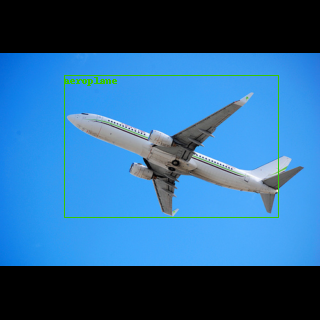

In [23]:
nms_tensor = nms(filtered_tensor, 0.5)
show_images_with_boxes(input_tensor, nms_tensor)

# Visualize final results on multiple images

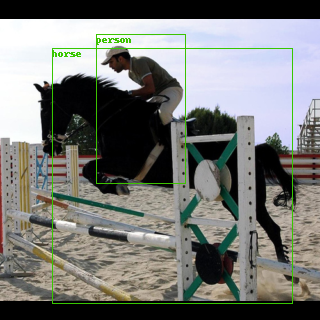

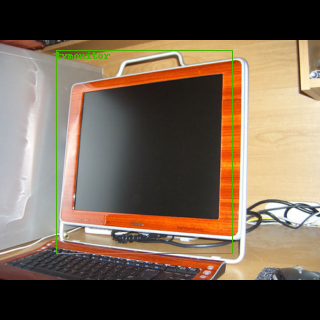

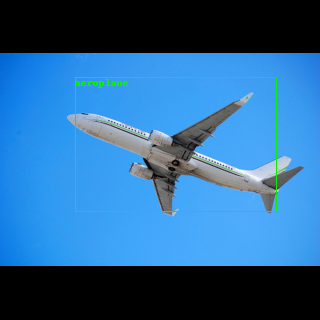

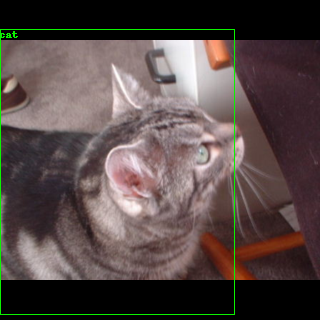

In [24]:
imgs = load_image_batch([8, 16, 33, 60], size=320)
output_tensor = network(imgs)
filtered_tensor = filter_boxes(output_tensor, 0.2)
nms_tensor = nms(filtered_tensor, 0.5)
show_images_with_boxes(imgs, nms_tensor)

## References
* Redmon, J., & Farhadi, A. (2016). [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242). arXiv preprint arXiv:1612.08242.
